# Junction Tree Algorithm

## Graphs

In [1]:
import json
import networkx as nx

def get_data():
    with open('./huang.json', 'r') as fp:
        return json.load(fp)
        
def get_dag():
    d = nx.DiGraph()
    d.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    d.add_edges_from([
        ('A', 'B'),
        ('A', 'C'),
        ('B', 'D'),
        ('C', 'E'),
        ('D', 'F'),
        ('E', 'F'),
        ('C', 'G'),
        ('E', 'H'),
        ('G', 'H')
    ])
    
    return d

def get_moralized_graph():
    m = nx.Graph()
    m.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    m.add_edges_from([
        ('A', 'B'),
        ('A', 'C'),
        ('B', 'D'),
        ('C', 'E'),
        ('D', 'F'),
        ('E', 'F'),
        ('C', 'G'),
        ('E', 'H'),
        ('G', 'H'),
        ('D', 'E'),
        ('E', 'G')
    ])
    return m

def get_triangulated_graph():
    t = nx.Graph()
    t.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    t.add_edges_from([
        ('A', 'B'),
        ('A', 'C'),
        ('B', 'D'),
        ('C', 'E'),
        ('D', 'F'),
        ('E', 'F'),
        ('C', 'G'),
        ('E', 'H'),
        ('G', 'H'),
        ('D', 'E'),
        ('E', 'G'),
        ('A', 'D'),
        ('A', 'E')
    ])
    return t

def get_junction_tree():
    t = nx.Graph()
    
    t.add_node('ABD', nodes=['A', 'B', 'D'], type='clique')
    t.add_node('ADE', nodes=['A', 'D', 'E'], type='clique')
    t.add_node('ACE', nodes=['A', 'C', 'E'], type='clique')
    t.add_node('CEG', nodes=['C', 'E', 'G'], type='clique')
    t.add_node('DEF', nodes=['D', 'E', 'F'], type='clique')
    t.add_node('EGH', nodes=['E', 'G', 'H'], type='clique')
    t.add_node('AD', nodes=['A', 'D'], type='sepset')
    t.add_node('AE', nodes=['A', 'E'], type='sepset')
    t.add_node('DE', nodes=['D', 'E'], type='sepset')
    t.add_node('CE', nodes=['C', 'E'], type='sepset')
    t.add_node('EG', nodes=['E', 'G'], type='sepset')

    t.add_edges_from([
        ('ABD', 'AD'),
        ('ADE', 'AD'),
        ('ADE', 'DE'),
        ('DEF', 'DE'),
        ('ADE', 'AE'),
        ('ACE', 'AE'),
        ('ACE', 'CE'),
        ('CEG', 'CE'),
        ('CEG', 'EG'),
        ('EGH', 'EG')
    ])
    
    return t

_dg = get_dag()
_mg = get_moralized_graph()
_tg = get_triangulated_graph()
_jg = get_junction_tree()

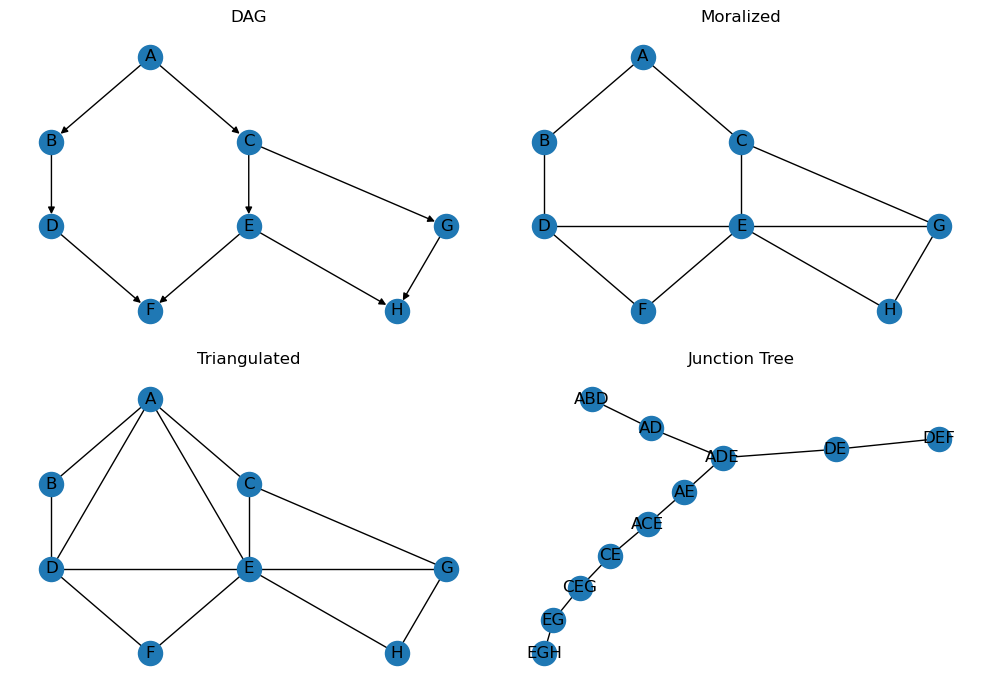

In [2]:
import matplotlib.pyplot as plt
import numpy as np

_g_pos = nx.nx_agraph.graphviz_layout(_dg, prog='dot')
_j_pos = nx.nx_agraph.graphviz_layout(_jg, prog='neato')

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = np.ravel(ax)

nx.draw(_dg, _g_pos, with_labels=True, ax=ax[0])
nx.draw(_mg, _g_pos, with_labels=True, ax=ax[1])
nx.draw(_tg, _g_pos, with_labels=True, ax=ax[2])
nx.draw(_jg, _j_pos, with_labels=True, ax=ax[3])

ax[0].set_title('DAG')
ax[1].set_title('Moralized')
ax[2].set_title('Triangulated')
ax[3].set_title('Junction Tree')

fig.tight_layout()

## Inference

In [3]:
D = get_data()

In [4]:
import itertools
import pandas as pd

def get_cpt(node):
    df = pd.DataFrame(D['cpt'][node])
    return df

def get_pot(nodes):
    df = (D['domain'][n] for n in nodes)
    df = itertools.product(*df)
    df = pd.DataFrame(df, columns=nodes) \
        .assign(**{'__p__': 1})
    return df

def multiply(L, R):
    COLUMNS = list(set(L.columns.drop('__p__')) & set(R.columns.drop('__p__')))
    return L \
        .set_index(COLUMNS) \
        .join(R.set_index(COLUMNS), lsuffix='lhs', rsuffix='rhs') \
        .assign(**{'__p__': lambda d: d['__p__lhs'] * d['__p__rhs']}) \
        .reset_index()[R.columns]

def marginalize(P, nodes):
    return P.groupby(nodes)['__p__'].sum().to_frame().reset_index()

def divide(N, D):
    COLUMNS = list(set(N.columns.drop('__p__')) & set(D.columns.drop('__p__')))
    return N.set_index(COLUMNS) \
        .join(D.set_index(COLUMNS), lsuffix='lhs', rsuffix='rhs') \
        .assign(**{'__p__': lambda d: d['__p__lhs'] / d['__p__rhs']}) \
        .reset_index()[D.columns]

def message(X, s, Y):
    COLUMNS = list(set(X.columns.drop('__p__')) & set(s.columns.drop('__p__')))
    r = divide(marginalize(X, COLUMNS), s)
    return X, r, multiply(r, Y)

def get_evidence(node, values=None):
    return pd.DataFrame({node: D['domain'][node]}) \
        .assign(**{'__p__': 1 if values is None else values})

def normalize(X):
    return X \
        .assign(**{'__p__': lambda d: d['__p__'] / d['__p__'].sum()})

In [5]:
_A = get_cpt('A')
_B = get_cpt('B')
_C = get_cpt('C')
_D = get_cpt('D')
_E = get_cpt('E')
_F = get_cpt('F')
_G = get_cpt('G')
_H = get_cpt('H')

_eA = get_evidence('A')
_eB = get_evidence('B')
_eC = get_evidence('C')
_eD = get_evidence('D')
_eE = get_evidence('E')
_eF = get_evidence('F')
_eG = get_evidence('G')
_eH = get_evidence('H', [1, 0])

_ABD = get_pot(['A', 'B', 'D'])
_ADE = get_pot(['A', 'D', 'E'])
_ACE = get_pot(['A', 'C', 'E'])
_DEF = get_pot(['D', 'E', 'F'])
_CEG = get_pot(['C', 'E', 'G'])
_EGH = get_pot(['E', 'G', 'H'])

_AD = get_pot(['A', 'D'])
_DE = get_pot(['D', 'E'])
_AE = get_pot(['A', 'E'])
_CE = get_pot(['C', 'E'])
_EG = get_pot(['E', 'G'])

### Initialization

In [6]:
_ABD = multiply(_D, multiply(_B, multiply(_A, _ABD)))
_ACE = multiply(_E, multiply(_C, _ACE))
_DEF = multiply(_F, _DEF)
_CEG = multiply(_G, _CEG)
_EGH = multiply(_H, _EGH)

In [7]:
_CLIQUES = {
    'ABD': _ABD.copy(),
    'ACE': _ACE.copy(),
    'DEF': _DEF.copy(),
    'CEG': _CEG.copy(),
    'EGH': _EGH.copy()
}

### Observation Entry

In [8]:
_ABD = multiply(_eD, multiply(_eB, multiply(_eA, _ABD)))
_ACE = multiply(_eE, multiply(_eC, _ACE))
_DEF = multiply(_eF, _DEF)
_CEG = multiply(_eG, _CEG)
_EGH = multiply(_eH, _EGH)

### Propagation

In [9]:
# distribute
_ABD, _AD, _ADE = message(_ABD, _AD, _ADE)
_DEF, _DE, _ADE = message(_DEF, _DE, _ADE)
_ADE, _AE, _ACE = message(_ADE, _AE, _ACE)
_EGH, _EG, _CEG = message(_EGH, _EG, _CEG)
_CEG, _CE, _ACE = message(_CEG, _CE, _ACE)

# collect
_ACE, _AE, _ADE = message(_ACE, _AE, _ADE)
_ADE, _DE, _DEF = message(_ADE, _DE, _DEF)
_ADE, _AD, _ABD = message(_ADE, _AD, _ABD)
_ACE, _CE, _CEG = message(_ACE, _CE, _CEG)
_CEG, _EG, _EGH = message(_CEG, _EG, _EGH)

### Marginalization + Normalization

In [10]:
normalize(marginalize(_ABD, ['A']))

,A,__p__
0,off,0.6014
1,on,0.3986


In [11]:
normalize(marginalize(_ABD, ['B']))

,B,__p__
0,off,0.56014
1,on,0.43986


In [12]:
normalize(marginalize(_ACE, ['C']))

,C,__p__
0,off,0.750771
1,on,0.249229


In [13]:
normalize(marginalize(_ABD, ['D']))

,D,__p__
0,off,0.324056
1,on,0.675944


In [14]:
normalize(marginalize(_ADE, ['E']))

,E,__p__
0,off,0.982504
1,on,0.017496


In [15]:
normalize(marginalize(_DEF, ['F']))

,F,__p__
0,off,0.677967
1,on,0.322033


In [16]:
normalize(marginalize(_CEG, ['G']))

,G,__p__
0,off,0.984386
1,on,0.015614


In [17]:
normalize(marginalize(_EGH, ['H']))

,H,__p__
0,off,0.0
1,on,1.0
